In [1]:
%load_ext blackcellmagic

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
from keras.layers import (
    Conv2D,
    Dense,
    Flatten,
    Input,
    MaxPooling2D,
    Reshape,
    UpSampling2D,
)
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

In [4]:
# CIFAR_10 = cifar10.load_data()
# CIFAR_100 = cifar100.load_data()
MNIST = mnist.load_data()
# FASHION_MNIST = fashion_mnist.load_data()

In [5]:
# this is the size of our encoded representations
ENCODING_DIM = 10

# decision boundary for classifier
THRESHOLD = 0.7

# working directory
CUR_DIR = os.path.abspath(os.path.curdir)

# setting random seed for reproducable results
np.random.seed(42)

In [6]:
def train_test_split(X, y, train_split=0.7, test_split=0.85):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # define boundaries for train,validation and test set at .7 and .85 % of the MNIST data set
    x_len = len(X)
    boundaries = [int(x_len * train_split), int(x_len * test_split)]

    [X_train, X_test, X_validate] = np.split(X, boundaries)

    [y_train, y_test, y_validate] = np.split(y, boundaries)
    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

In [7]:
def get_data(dataset, train_split=0.7, test_split=0.85):
    """retrieves data set and rebalances dataset, such that train=.7, test=.15 and validation=.15.
    :param dataset is assumed to be loaded from keras.datasets, thus the from 2-tuple(2-tuple) is assumed."""
    if not (len(dataset) == 2 and all([len(d) == 2 for d in dataset])):
        raise ValueError(
            "Datset has not the correct form. Please load from keras.datasets or convert to similar form."
        )

    (X_train, y_train), (X_test, y_test) = dataset
    if len(X_train.shape) == 3: # MNIST data set
        X_train = X_train.reshape((list(X_train.shape) + [1])) /255.0
        test_len = len(X_test)
        X_test = X_test.reshape((list(X_test.shape) + [1])) / 255.0

    # divide X values bei 255.0 since MNIST data set changed such that pixel values are in [0,255]
    X = np.concatenate((X_train, X_test)) 
    y = np.concatenate((y_train, y_test))

    (X_train, X_test, X_validate), (y_train, y_test, y_validate) = train_test_split(
        X, y
    )  # default: .7, .85
    # one-hot encode target columns
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_validate = to_categorical(y_validate)

    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

In [266]:
(X_train, X_test, X_validate), (y_train, y_test, y_validate) = get_data(MNIST)
#plt.imshow(X_train[3].reshape((28,28)),cmap="gray")

In [268]:
X_train.shape

(49000, 28, 28, 1)

In [10]:
def get_specific_data_set(X, y, digit):
    # parameters are training AND test data for X respectively y 
    # is assumed to be in one-hot-encoding
    y = np.argmax(y, axis=1)
    indices = np.where(y == digit)

    # filtering by the passed digit. needs to be an int
    X_digit = X[indices]    
    y_digit = y[indices]
     
    y_digit = to_categorical(y_digit) # array of length 2 of form [0., 1.]
    
    # splitting into training and test set is not necessary since the data for single digits
    # is just used for evaluation purposes (except for "1")
    
    return [X_digit, y_digit]

In [11]:
X = np.concatenate((X_train, X_test, X_validate))
y = np.concatenate((y_train, y_test, y_validate))
X.shape, y.shape

((70000, 28, 28, 1), (70000, 10))

In [12]:
# digit = 0
# X_zero, y_zero = get_specific_data_set(X, y, digit)
# digit = 8
# X_eight, y_eight = get_specific_data_set(X, y, digit)
# digit = 1
# X_one, y_one =  get_specific_data_set(X, y, digit)
# digit = 7
# X_seven, y_seven = get_specific_data_set(X, y, digit)
digit_data = [get_specific_data_set(X, y, i) for i in range(10)]

all_digits = X[np.where(np.argmax(y,axis=1)!= 1)]

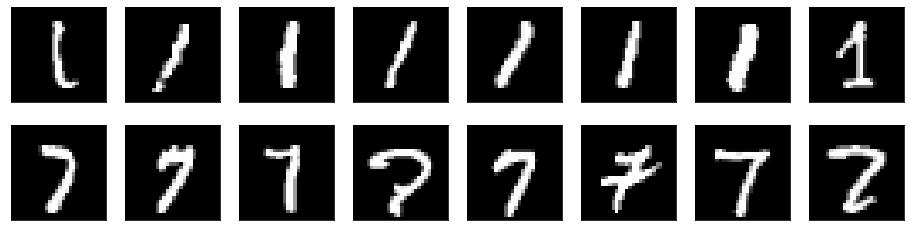

In [13]:
plt.figure(figsize=(16, 4))
# normalities
for i in range(len(digit_data[1][0][0]))[:8]:
    ax = plt.subplot(2, 8, i+1)
    plt.imshow(digit_data[1][0][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# anomalies
for i in range(len(digit_data[1][0][0]))[:8]:
    ax = plt.subplot(2, 8, 8+i+1)
    plt.imshow(digit_data[7][0][i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [14]:
def build_classifier(input_dim):
    """Builds classifier for classification of MNIST encoded representation."""
    classifier = Sequential()
    classifier.add(Dense(32, activation="relu", input_dim=input_dim,
                         kernel_initializer="random_normal"))
    classifier.add(Dense(ENCODING_DIM, activation="softmax",
                         kernel_initializer="random_normal"))

    classifier.compile(optimizer='adam', loss='mean_squared_error',
                       metrics=['accuracy'])
    return classifier

In [15]:
def build_conv_aue():
    INPUT_SHAPE = (28, 28, 1)
    DEFAULT_KERNEL = (3, 3)
    DEFAULT_POOL_SIZE = (2, 2)
    # this is our input placeholder
    input_img = Input(shape=INPUT_SHAPE)
    # layer between input and middle layer
    encode = Conv2D(16, DEFAULT_KERNEL, activation="relu", padding="same")(input_img)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(8, DEFAULT_KERNEL, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(8, DEFAULT_KERNEL, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(6, DEFAULT_KERNEL, activation="relu", padding="same")(encode)

    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same", name="encoder")(encode)

    # layer between middle and output layer
    decode = Conv2D(6, DEFAULT_KERNEL, activation="relu", padding="same")(encoded)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(8, DEFAULT_KERNEL, activation="relu", padding="same")(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(8, DEFAULT_KERNEL, activation="relu", padding="same")(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(16, DEFAULT_KERNEL, activation="relu")(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decoded = Conv2D(1, DEFAULT_KERNEL, activation="sigmoid", padding="same")(decode)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decoded)

    encoder, decoder = get_codec_from_aue(autoencoder)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")
    return autoencoder, encoder, decoder

In [16]:
def get_codec_from_aue(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [ ]:
# array to map digits to verbose representation to store model with appropriate naming
digits_verbose = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
]

In [265]:
X_validate.shape

(10500, 28, 28, 1)

**all digits auto encoder**

In [19]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "all-conv-ae.hdf5")

if os.path.isfile(ckpt_loc):
    print("Loading Autoencoder for all digits from directory %s..." % ckpt_loc)
    all_ae = load_model(ckpt_loc)
    all_encoder, all_decoder = get_codec_from_aue(all_ae)
else:
    print("Training Autoencoder for all digits...")
    all_ae, all_encoder, all_decoder = build_conv_aue()
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, mode="min", min_delta=0.0005
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    all_ae.fit(
        X_train,
        X_train,
        epochs=128,
        batch_size=128,
        shuffle=True,
        validation_data=(X_validate, X_validate),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    )
all_ae.summary()

Loading Autoencoder for all digits from directory C:\Users\a642196\coding\CNN-auto-encoder\ckpts\all-conv-ae.hdf5...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 8)           0         
_____________________________________

In [20]:
eval_train = all_ae.evaluate(X_train, X_train)
eval_validate = all_ae.evaluate(X_validate, X_validate)
eval_test = all_ae.evaluate(X_test, X_test)
eval_train, eval_validate,eval_test

10500/10500 [==============================] - 3s 313us/step


(0.12209377393552236, 0.1222446245834941, 0.12298459164301555)

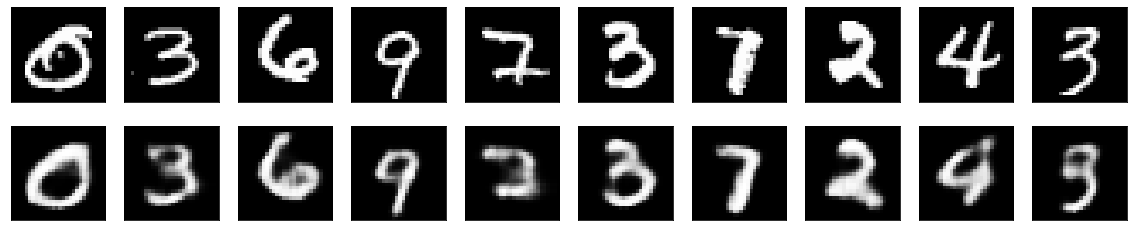

In [21]:
encoded_imgs_train = all_encoder.predict(X_train)
encoded_imgs_validate = all_encoder.predict(X_validate)
encoded_imgs_test = all_encoder.predict(X_test)

decoded_imgs = all_decoder.predict(encoded_imgs_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "all-conv-ae.png"))

**"one" auto encoder**

Learning features of the digit one. Afterwards, the distribution of the features will be computed to detect outliers which have low probability.

In [22]:
X_one = digit_data[1][0]
y_one = digit_data[1][1]

(X_one_train, X_one_test, X_one_validate), (
    y_one_train,
    y_one_test,
    y_one_validate,
) = train_test_split(X_one, y_one)
len(X_one_train), len(X_one_test), len(X_one_validate)

(5513, 1182, 1182)

In [23]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "%s-conv-ae.hdf5" % digits_verbose[1])

if os.path.isfile(ckpt_loc):
    print("Loading Autoencoder %s from directory %s..." % (digits_verbose[1], ckpt_loc))
    one_ae = load_model(ckpt_loc)
    one_encoder, one_decoder = get_codec_from_aue(one_ae)
else:
    print("Training Autoencoder for digit %s..." % digits_verbose[1])
    one_ae, one_encoder, one_decoder = build_conv_aue()
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, mode="min", min_delta=0.0005
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    tb = TensorBoard(
        log_dir="./ckpts", histogram_freq=0, write_graph=True, write_images=True
    )
    one_ae.fit(
        X_one_train,
        X_one_train,
        epochs=128,
        batch_size=128,
        shuffle=True,
        validation_data=(X_one_validate, X_one_validate),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tb],
    )
one_ae.summary()

Loading Autoencoder one from directory C:\Users\a642196\coding\CNN-auto-encoder\ckpts\one-conv-ae.hdf5...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 7, 7, 8)           584       
____________________________________

In [24]:
eval_one_train = one_ae.evaluate(X_one_train, X_one_train)
eval_one_validate = one_ae.evaluate(X_one_validate, X_one_validate)
eval_one_test = one_ae.evaluate(X_one_test, X_one_test)
eval_one_train, eval_one_validate, eval_one_test

1182/1182 [==============================] - 0s 385us/step


(0.05896099324699822, 0.058588318091812475, 0.058639888060728305)

In [25]:
encoded_one_imgs_train = one_encoder.predict(X_one_train)
encoded_one_imgs_validate = one_encoder.predict(X_one_validate)
encoded_one_imgs_test = one_encoder.predict(X_one_test)

## Reconstructed "1" with auto encoder

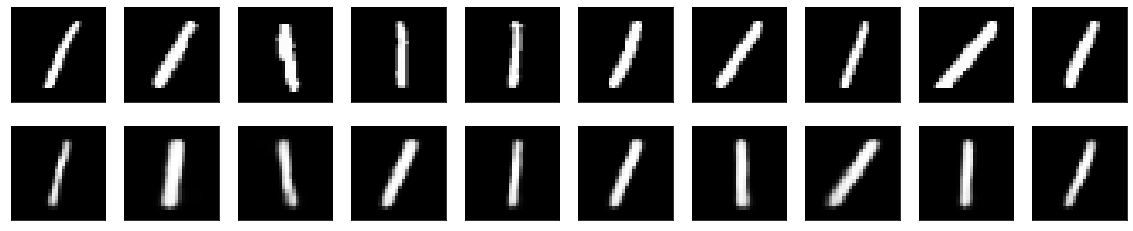

In [26]:
decoded_one_imgs = one_decoder.predict(encoded_one_imgs_train)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_one_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_one_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "one-conv-ae.png"))

## Reconstructed "7" (aka anomaly) with auto encoder

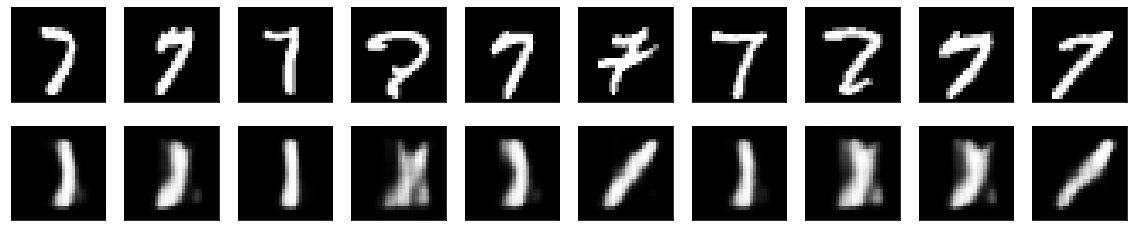

In [27]:
decoded_sevens_imgs = one_ae.predict(digit_data[7][0])
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(digit_data[7][0][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_sevens_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "seven-conv-one-ae.png"))

## Anomaly detection with root of squared loss per pixel

In [28]:
def loss_per_img(img,rec_img):
    return np.sqrt(np.sum(np.power(rec_img - img,2)))

In [29]:
anomaly_losses = np.array([])
# for img in digit_data[7][0]:


sevens = digit_data[7][0]
imgs = sevens.reshape(-1, 28, 28, 1)
rec_imgs = one_ae.predict(imgs)
seven_losses = np.array([loss_per_img(i, ri) for i, ri in zip(imgs, rec_imgs)])

imgs = all_digits#.reshape(-1,28,28,1)
rec_imgs = one_ae.predict(imgs)
all_digits_losses = np.array([loss_per_img(i,ri) for i,ri in zip(imgs,rec_imgs)])

seven_losses.max(), seven_losses.mean()

(11.82006814421953, 6.998416267523863)

In [30]:
normal_losses = np.array([])
imgs = X_one_test.reshape(len(X_one_test),28,28,1)
rec_imgs = one_ae.predict(imgs)
normal_losses = np.array([loss_per_img(i,ri) for i,ri in zip(imgs,rec_imgs)])

normal_losses.max(), normal_losses.mean()

(8.096025613804176, 2.2190365651852173)

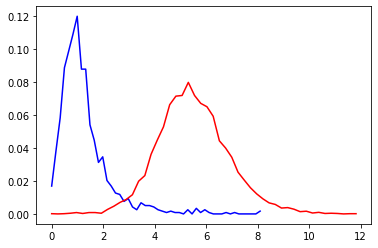

In [31]:
# loss distribution over the normal dataset
bins = 50
t = np.linspace(0, normal_losses.max(), bins)
hist_normal = np.histogram(normal_losses, bins=bins)
plt.plot(t, hist_normal[0] / len(normal_losses), "b")

# loss distribution over the anomaly dataset for digit "seven"
hist_sevens = np.histogram(seven_losses, bins=bins)
t = np.linspace(0, seven_losses.max(), bins)
plt.plot(t, hist_sevens[0] / len(seven_losses), "r")

# loss distribution over the anomaly dataset for all digits
#hist_all = np.histogram(all_digits_losses, bins=bins)
#t = np.linspace(0, all_digits_losses.max(), bins)
#plt.plot(t, hist_all[0] / len(all_digits_losses), "g")
plt.show()

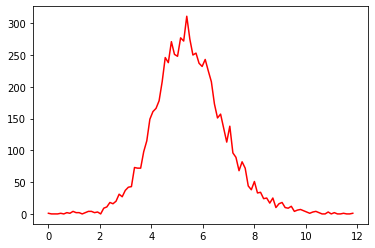

In [32]:
# loss distribution over the anomaly dataset
bins = 100
hist_anomaly = np.histogram(seven_losses, bins=bins)
t = np.linspace(0, seven_losses.max(), bins)
plt.plot(t, hist_anomaly[0], "r")
plt.show()

i:0.900 * ratio:0.000 = 0.000
i:0.905 * ratio:0.000 = 0.000
i:0.910 * ratio:0.000 = 0.000
i:0.915 * ratio:0.000 = 0.000
i:0.920 * ratio:0.000 = 0.000
i:0.925 * ratio:0.000 = 0.000
i:0.930 * ratio:0.001 = 0.001
i:0.935 * ratio:0.001 = 0.001
i:0.940 * ratio:0.001 = 0.001
i:0.945 * ratio:0.002 = 0.001
i:0.950 * ratio:0.002 = 0.002
i:0.955 * ratio:0.002 = 0.002
i:0.960 * ratio:0.003 = 0.003
i:0.965 * ratio:0.003 = 0.003
i:0.970 * ratio:0.004 = 0.004
i:0.975 * ratio:0.005 = 0.005
i:0.980 * ratio:0.008 = 0.008
i:0.985 * ratio:0.030 = 0.030
i:0.990 * ratio:0.128 = 0.127
i:0.995 * ratio:0.216 = 0.215


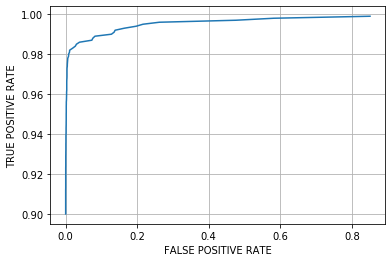

In [33]:
# x:= "false detected anomalies in %"
# y:= "correct detected normal data points in %"
rs = []
prec = 1000
step_size = 1 / prec
decs = np.arange(0.9, 1, step_size)
for i in decs:  # i == 0.98 seems to be a valid value
    loss_boundary = np.sort(normal_losses)[
        int(len(normal_losses) * i)
    ]  # loss value for detection of i% normal data points
    x = seven_losses[
        np.where(seven_losses < loss_boundary)
    ]  # loss values for anomalies which are below than the boundary
    ratio_of_undetected = len(x) / len(
        seven_losses
    )  # ratio between not detected loss values for anomalies
    rs = np.append(rs, ratio_of_undetected)
    if (int(i * prec)) % int(prec / 200) == 0:
        print(
            "i:%.3f * ratio:%.3f = %.3f"
            % (i, ratio_of_undetected, i * ratio_of_undetected)
        )
plt.plot(rs, decs)  # ,zs=decs*rs)
plt.grid()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.show()

In [34]:
loss_boundary = np.sort(normal_losses)[int(len(normal_losses) * 0.98)]
ind_undetected_anomalies = np.where(
    seven_losses < loss_boundary
)  # indices for undetected anomalies in the data set
ind_detected_normals = np.where(
    normal_losses >= loss_boundary
)  # indices for as anomaly detected normal data points in the data set

detected_normals = X_one_test[ind_detected_normals]
undetected_anomalies = digit_data[7][0][ind_undetected_anomalies]
loss_boundary, len(detected_normals)

(4.667351439200281, 24)

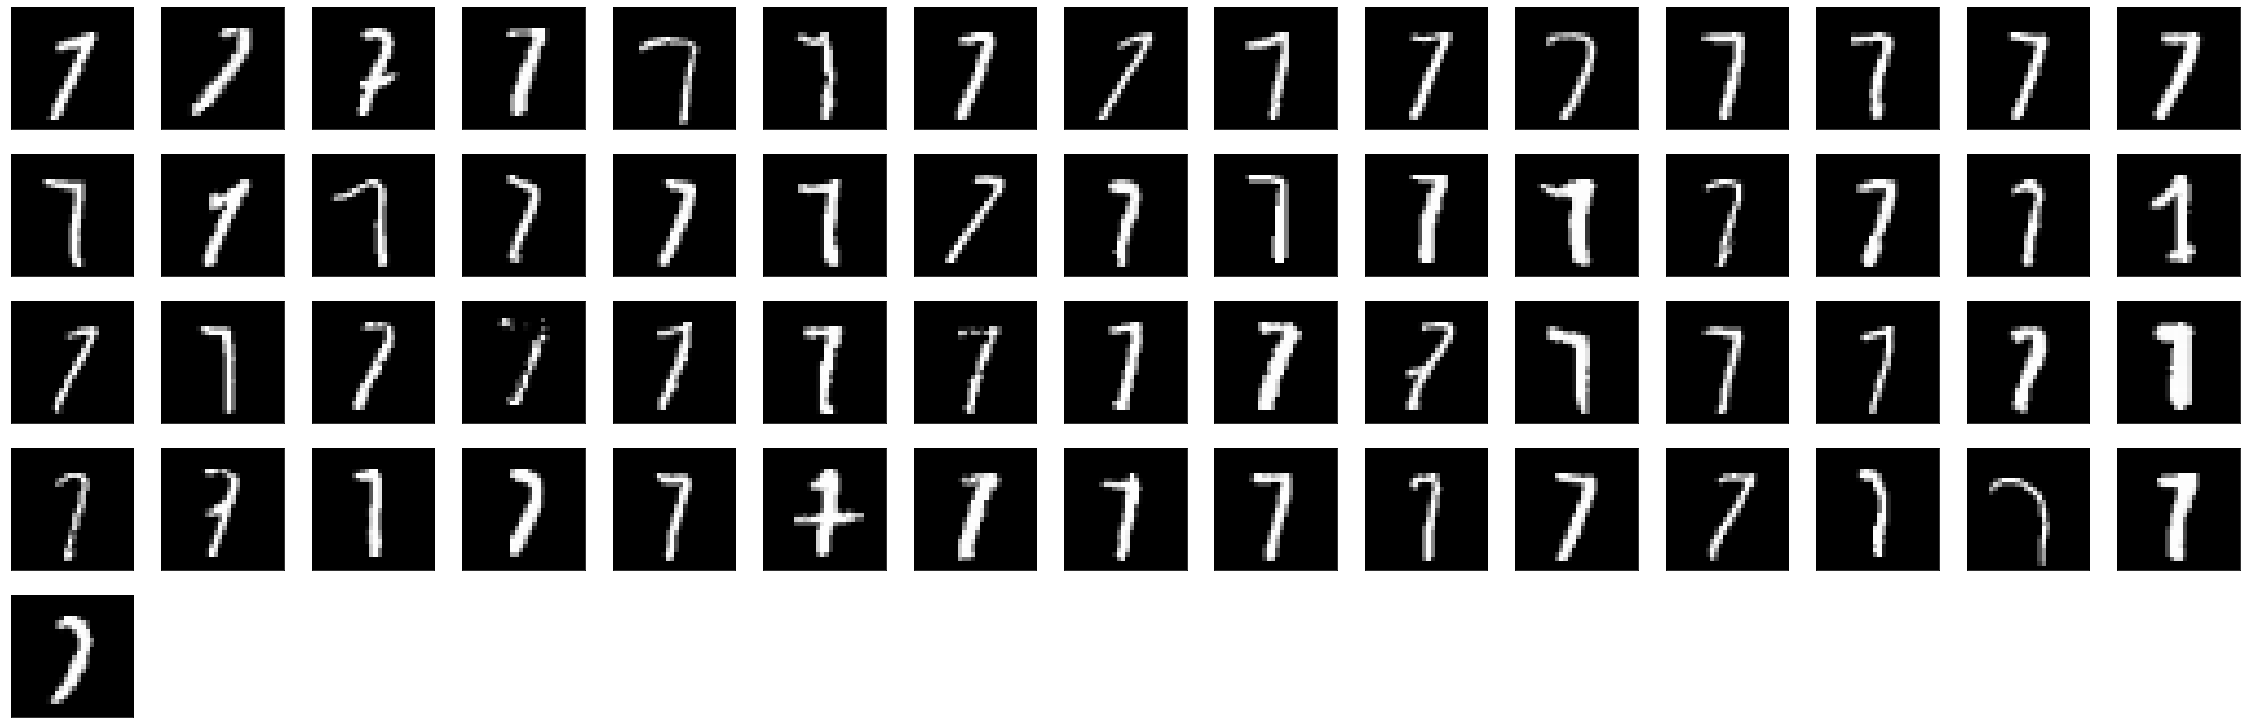

In [35]:
n = len(undetected_anomalies)  # how many digits we will display
plt.figure(figsize=(40, 32))
for i in range(n):
    ax = plt.subplot(n/5, n/4, i + 1)
    plt.imshow(undetected_anomalies[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "undetected-sevens.png"))

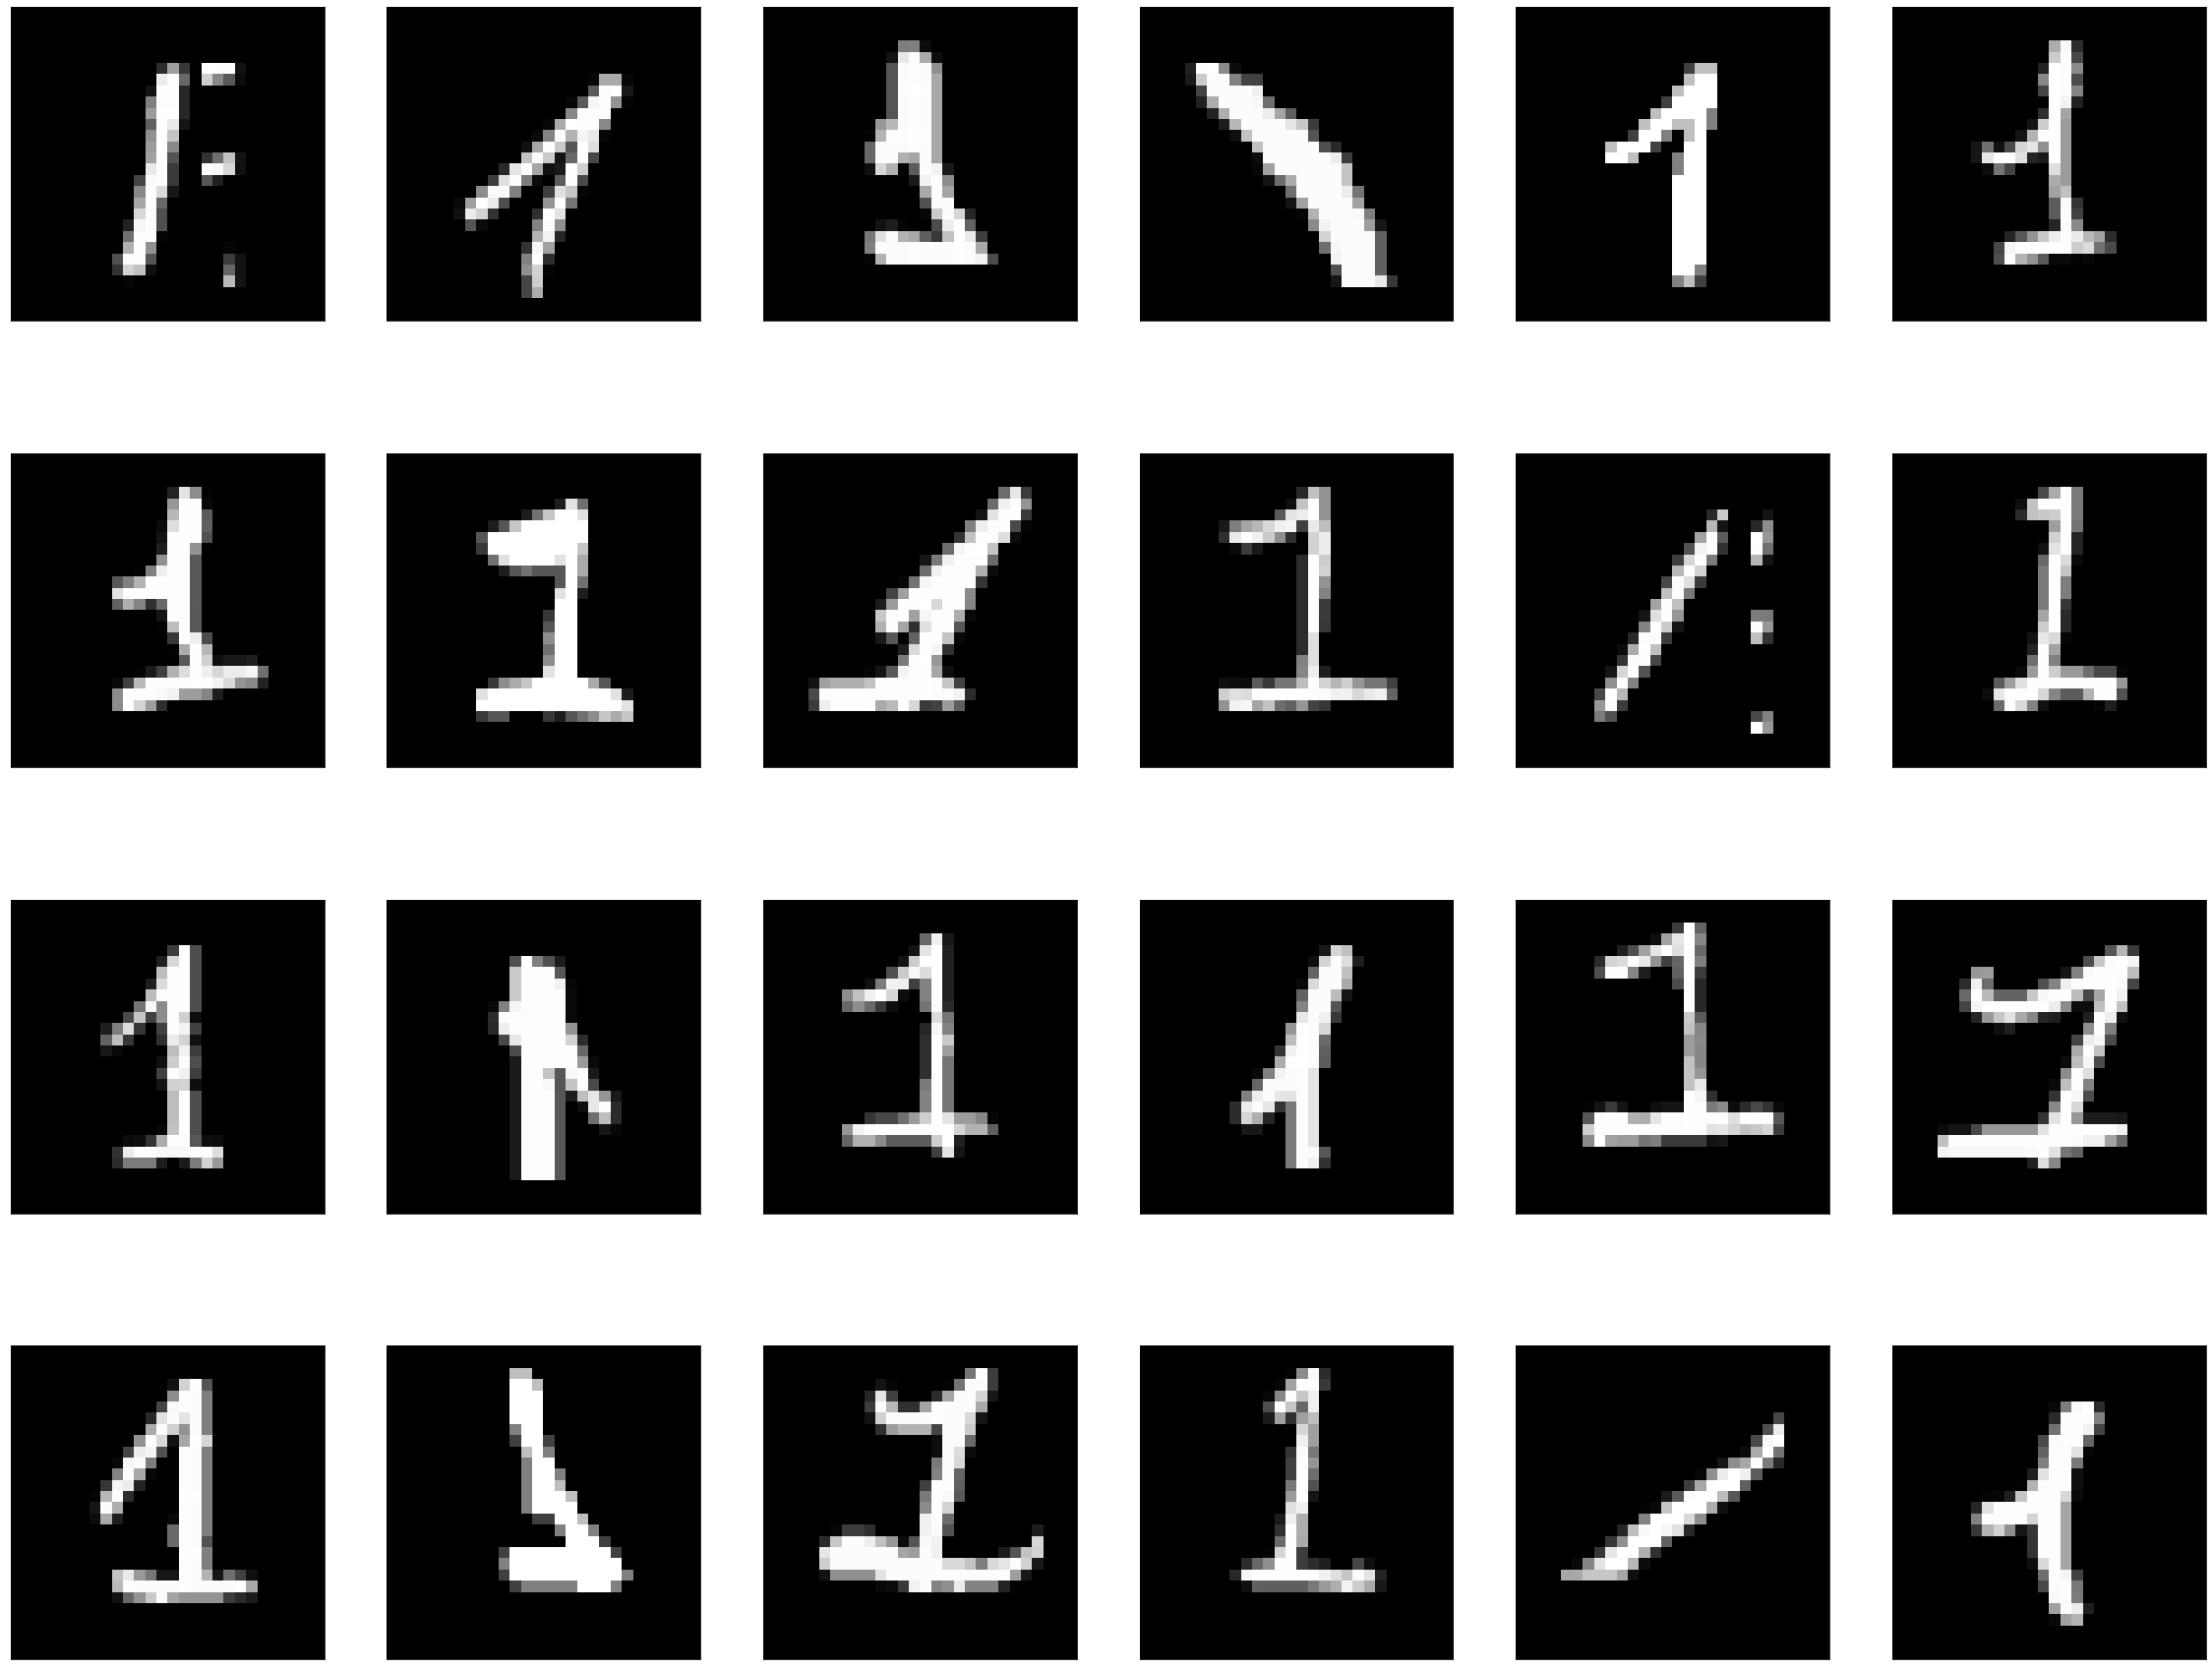

In [36]:
# display digits "1" which have been detected as normaility 
n = len(detected_normals)  # how many digits we will display
plt.figure(figsize=(40, 32))
for i in range(n):
    ax = plt.subplot(n/5, n/4, i + 1)
    plt.imshow(detected_normals[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "detected-ones.png"))

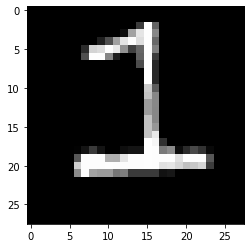

In [37]:
# digit "1" with highest loss (in test set). improves understandibility of why this might be identified incorrectly.
plt.imshow(X_one_test[np.argmax(normal_losses)].reshape((28,28)))
plt.show()

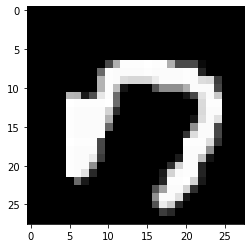

In [38]:
# what even is this? "7" with maximum loss (biggest difference to digit "1")
plt.imshow(digit_data[7][0][np.argmax(seven_losses)].reshape((28,28)))
plt.show()

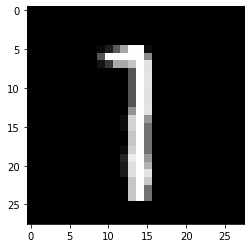

In [39]:
# this is supposed to be a seven. minimal loss for a digit in the "anomaly" (aka "7") data set
plt.imshow(digit_data[7][0][np.argmin(seven_losses)].reshape((28,28)))
plt.show()

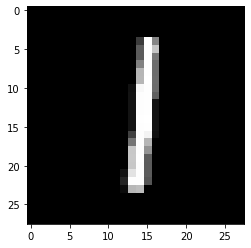

In [40]:
# this is supposed to be a seven. minimal loss for a digit in the "anomaly" (aka "7") data set
plt.imshow(X_one_test[np.argmin(normal_losses)].reshape((28,28)))
plt.show()

## All digits classifier

In [41]:
flat = np.prod(encoded_imgs_train.shape[1:], dtype=np.int64)
encoded_imgs_train = encoded_imgs_train.reshape(len(encoded_imgs_train), flat)
encoded_imgs_validate = encoded_imgs_validate.reshape(
    len(encoded_imgs_validate), flat)
encoded_imgs_test = encoded_imgs_test.reshape(len(encoded_imgs_test), flat)

In [42]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "classifier.hdf5")
if os.path.isfile(ckpt_loc):
    print("Loading classifier from directory %s..." % ckpt_loc)
    classifier = load_model(ckpt_loc)
else:
    print("Training classifier...")
    classifier = build_classifier(input_dim=flat)
    earlyStopping = EarlyStopping(
        monitor="val_acc", patience=5, verbose=1, mode="max", min_delta=0.0005
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_acc", mode="max"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_acc", factor=0.3, patience=3, verbose=1, mode="max"
    )
    classifier.fit(
        encoded_imgs_train,
        y_train,
        validation_data=(encoded_imgs_validate, y_validate),
        batch_size=16,
        epochs=32,
        shuffle=True,
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    )
classifier.summary()

Loading classifier from directory C:\Users\a642196\coding\CNN-auto-encoder\ckpts\classifier.hdf5...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 1,130
Trainable params: 1,130
Non-trainable params: 0
_________________________________________________________________


In [43]:
eval_train = classifier.evaluate(encoded_imgs_train, y_train)
eval_validate = classifier.evaluate(encoded_imgs_validate, y_validate)
eval_test = classifier.evaluate(encoded_imgs_test, y_test)
eval_train,eval_validate, eval_test

10500/10500 [==============================] - 0s 27us/step


([0.00998854218392956, 0.9347551020408164],
 [0.010621406028801132, 0.9284761904761905],
 [0.01085971775721936, 0.9284761904761905])

In [44]:
def get_cm(input, y_true):
    """Computes confusion matrix."""
    y_pred = tf.argmax(classifier.predict(input), axis=1)
    y_true = tf.argmax(y_true, axis=1)

    c = tf.keras.backend.eval(y_pred)
    d = tf.keras.backend.eval(y_true)

    return confusion_matrix(c, d)

In [45]:
def precision(cm):
    results = []
    for i in range(len(cm)):  # rows
        TP = cm[i][i]
        fp_tp = np.sum(cm[i])
        results.append(TP / fp_tp)
    return results + [np.mean(results)]

In [46]:
def recall(cm):
    results = []
    for i in range(len(cm)):  # rows
        TP = cm[i][i]
        tp_fn = 0
        for j in range(len(cm[i])):
            tp_fn += cm[j][i]
        results.append(TP/tp_fn)
    return results + [np.mean(results)]

In [47]:
cm_train = get_cm(encoded_imgs_train, y_train)
print(cm_train, precision(cm_train)[-1], recall(cm_train)[-1], sep="\n")

cm_validate = get_cm(encoded_imgs_validate, y_validate)
print(cm_validate, precision(cm_validate)[-1], recall(cm_validate)[-1], sep="\n")

cm_test = get_cm(encoded_imgs_test, y_test)
print(cm_test, precision(cm_test)[-1], recall(cm_test)[-1], sep="\n")

[[4800    1   57   27   12   34   34   15   49   57]
 [   1 5368   14   20   23   10   11   29   32   19]
 [   4   42 4616  109   34   24    9   56   40   17]
 [   0   20   56 4525   15  105    2   28   63   55]
 [   5    4   12    8 4181    9   13   28   33  106]
 [   8    5    9   82    3 4123   35    7   91   20]
 [  12    2    8    3   70   39 4739    0   38    0]
 [   2    7   47   32   10    3    0 4676   13  120]
 [  27   18   61  111   86   75   25   33 4339   81]
 [   3   10    9   24  284   22    0  272   48 4436]]
0.9347102538187887
0.9341304435680249
[[ 999    0   19    4    2    9   11    3   16   14]
 [   0 1182    3    8    7    4    3    8   14    6]
 [   1   12 1029   15   11    5    0   11    7    5]
 [   1    3    9  959    2   24    1    6    5   22]
 [   0    3    3    0  895    2    2    3    6   17]
 [   3    4    2   22    0  881    6    2   24    8]
 [   2    1    0    0   15   10  995    0   14    0]
 [   0    2   12    9    1    0    0  983    3   28]
 [  11 

# Feature distribution with DJ CF Gauss

In [48]:
one_flat = np.prod(encoded_one_imgs_train.shape[1:], dtype=np.int64)
encoded_one_imgs_train = encoded_one_imgs_train.reshape(
    len(encoded_one_imgs_train), one_flat
)
encoded_one_imgs_validate = encoded_one_imgs_validate.reshape(
    len(encoded_one_imgs_validate), one_flat
)
encoded_one_imgs_test = encoded_one_imgs_test.reshape(
    len(encoded_one_imgs_test), one_flat
)

In [49]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i else 0
    return np.array(
        (1 / np.sqrt(2 * np.pi * sigma_i2))
        * np.exp(-(x_i - my_i) ** 2 / (2 * sigma_i2))
    )

In [50]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [51]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([(1/m)*np.sum((X[:, i] - my[i]) ** 2) for i in range(len(my))])

In [52]:
def p(X,my,sigma2):
    return np.array([np.prod([gauss(x[i], my[i], sigma2[i])
               for i in range(len(x))]) for x in X])

In [223]:
X = encoded_one_imgs_test

In [66]:
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
p_all[p_all > 0.0001]

array([0.0003197 , 0.00011112, 0.00012036, 0.00020606, 0.00010436,
       0.00012751, 0.00021457, 0.00010162, 0.00021343, 0.00010372,
       0.00011442, 0.00015182, 0.00011803, 0.00017035, 0.00011706,
       0.00011271, 0.00011769, 0.00013339, 0.00010214, 0.00021844,
       0.00014009, 0.00011139, 0.00018007, 0.00013337])

# One Class SVM

In [190]:
from sklearn import svm
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score,accuracy_score

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, nu=0.3, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

((1000, 24), (5513, 24))

In [263]:
for i in np.arange(0.2,.7, 0.1):
    clf = svm.OneClassSVM(gamma="auto", nu=i)
    clf.fit(encoded_one_imgs_train)
    encoded_sevens = one_encoder.predict(digit_data[7][0])#[1000:2000])
    flat = np.prod(encoded_sevens.shape[1:], dtype=np.int64)
    encoded_sevens = encoded_sevens.reshape(-1,flat)
    encoded_sevens.shape, encoded_one_imgs_train.shape

    bins = 2
    scores_1 = clf.predict(encoded_one_imgs_test)
    # hist_oc = np.histogram(scores_1, bins)
    # t = np.linspace(scores_1.min(), scores_1.max(), bins)
    #plt.bar(t, hist_oc[0], width=0.5, color="r")
    # plt.show()
    scores_7 = clf.predict(encoded_sevens)

    # hist_oc_p = np.histogram(scores_7, bins)
    # t = np.linspace(scores_7.min(), scores_7.max(), bins)
    #plt.bar(t, hist_oc_p[0], width=0.5, color="b")
    # plt.show()

    scores = np.concatenate((scores_1, scores_7))
    y_truth = np.concatenate((np.ones(len(scores_1)), -np.ones(len(scores_7))))
    # precision, recall, thresholds = precision_recall_curve(y_truth, X)
    # accuracy = accuracy_score(y_truth, X)

    TP = len(scores_1[scores_1 == 1])
    FN = len(scores_1[scores_1 == -1])

    TN = len(scores_7[scores_7 == -1])
    FP = len(scores_7[scores_7 == 1])

    accuracy = (TP + TN) / len(scores)
    precision = TP / (TP + FN)
    recall = TP / (TP + FP)
    print("%.2f"%i, accuracy, precision, recall)
    

0.20 0.871976401179941 0.8104906937394247 0.5266630016492578
0.30 0.9065486725663717 0.7182741116751269 0.6490825688073395
0.40 0.9110324483775811 0.6159052453468697 0.708171206225681
0.50 0.9092625368731564 0.5126903553299492 0.7584480600750939
0.60 0.9020648967551622 0.4069373942470389 0.7885245901639344


### Distribution of Encoded Features

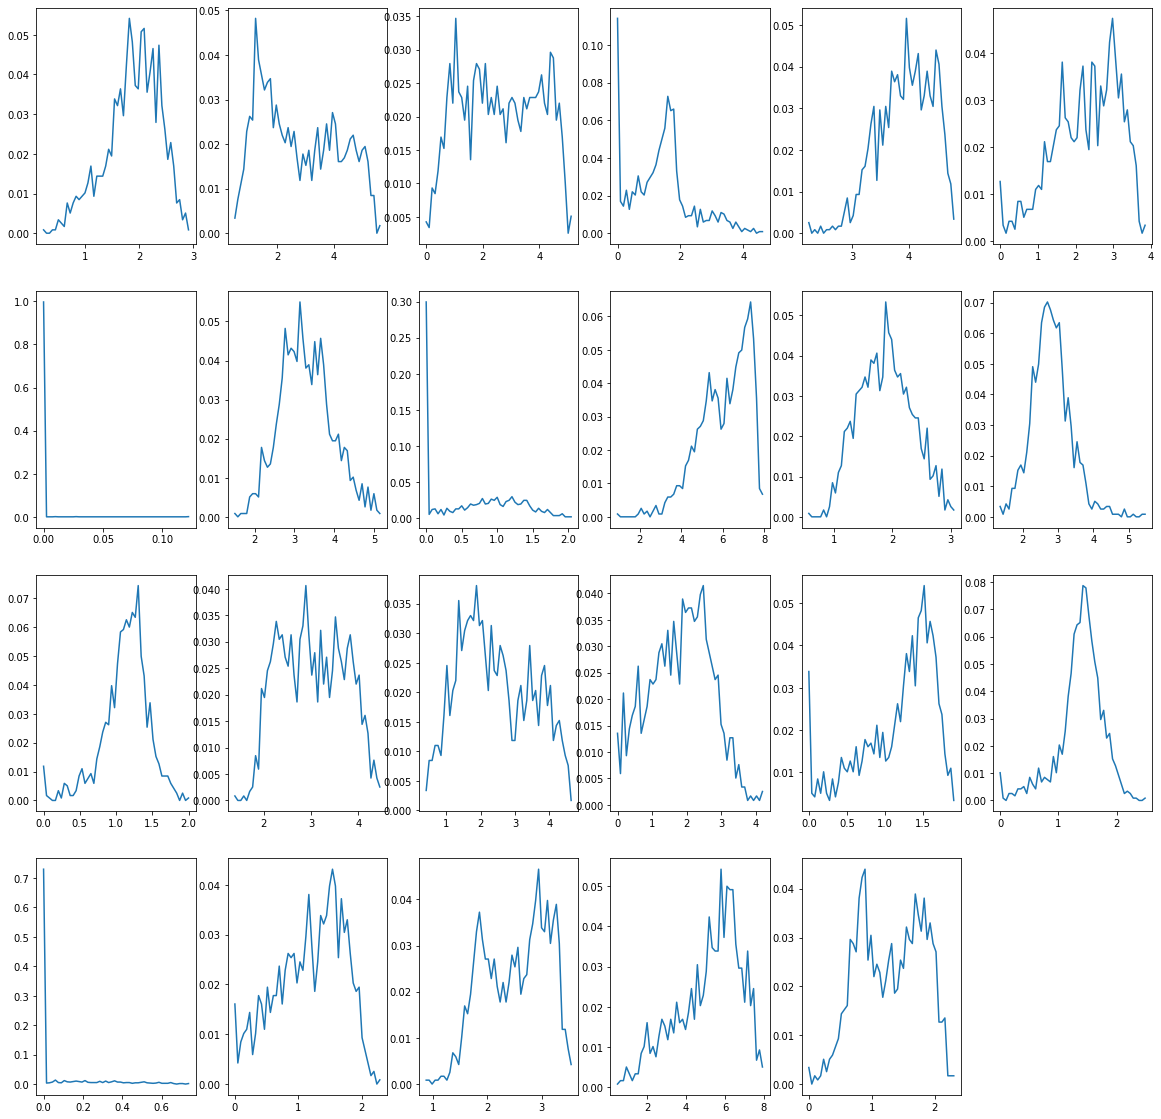

In [230]:
plt.figure(figsize=(20, 20))
for i in range(len(my)-1):
    # plots distribution of i-th feature
    # display original
    bins = 50
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    h_min = min(X[:, i])
    h_max = max(X[:, i])
    r = np.linspace(start=h_min, stop=h_max, num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))

In [225]:
def convert_values_to_img(values):
    values = np.reshape(values, (1, 2, 2, 6))
    random_img = decoder.predict(values)
    return np.reshape(random_img, (28, 28))

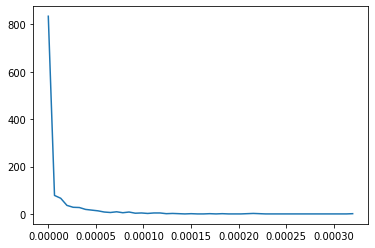

In [231]:
bins = 50
hist_all = np.histogram(p_all, bins=bins)
r = np.linspace(min(p_all), max(p_all), bins)
plt.plot(r, hist_all[0])

# Getting fashion-y

In [ ]:
def get_fashion():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    img = X_train[0].reshape((28, 28))
    # reshape data to fit model
    plt.imshow(X_train[1], cmap="Greys", vmin=0, vmax=255)
    plt.savefig("fashion_example_img.png")

    """for Autoencoder"""
    X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
    X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
    # np.random.shuffle(X_test)
    X_validate = X_test[len(X_test) // 2 :]
    X_test = X_test[: len(X_test) // 2]

    return X_train / 255.0, X_test / 255.0, X_validate / 255.0

In [ ]:
X_fashion_train, X_fashion_test, X_fashion_validate = get_fashion()
print(X_fashion_test[:5])

# Colored images

In [ ]:
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dic = pickle.load(fo, encoding="bytes")
    return dic

In [ ]:
data_path = os.path.join(CUR_DIR, "data", "cifar-10-batches-py")
train_batches = []
test_batch = []
for filename in os.listdir(data_path):
    filename = os.path.join(data_path, filename)
    if "data_batch" in filename:
        train_batches.append(unpickle(filename))  # keys: labels, data, filenames
    if "test_batch" in filename:
        test_batch = unpickle(filename)
len(train_batches), test_batch

In [ ]:
data_path = os.path.join(CUR_DIR, "data", "cifar-100-python")
train_batches = []
test_batch = []
for filename in os.listdir(data_path):
    filename = os.path.join(data_path, filename)
    if "train" in filename:
        train_batches = unpickle(filename)  # keys: labels, data, filenames
    if "test" in filename:
        test_batch = unpickle(filename)
len(train_batches), test_batch